# Задача 3

In [1]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps

Сгенерируем коэф-ты $a$ из стандартного нормального распределения с $\sigma^2=16$. Для генерации шума возьмем $\sigma=1$, по предложенным формулам посчитаем $y^{ист}$ и $y^{наб}$

In [2]:
m = 200
params_sigma = 4
noise_sigma = 1
names = ['a0', 'a1', 'a2']
a = sps.norm(loc=0, scale=params_sigma).rvs(3)

In [3]:
print('Sigma = {}'.format(noise_sigma))
for var_name, cur_value in zip(names, a):
    print('{} = {}'.format(var_name, cur_value))

Sigma = 1
a0 = -1.217468213081824
a1 = -3.287669280788074
a2 = 3.572607202161871


In [4]:
t = 10 * np.arange(0, m) / (m - 1)
X = np.zeros((m, 3))
X[:, 0] = 1
X[:, 1] = t
X[:, 2] = np.sin(t)
initial_target = X @ a
noised_target = initial_target + sps.norm(loc=0, scale=noise_sigma).rvs(len(initial_target))

## Случай L2

Из семинара знаем, что $(a_0^{оц}, a_1^{оц}, a_2^{оц}) = (X^T X)^{-1}X^T y^{наб}$ в случае квадратичной нормы

In [5]:
def solve_l2(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

In [6]:
estimated_a2 = solve_l2(X, noised_target)

In [7]:
for var_name, real_value, estimated_value in zip(names, a, estimated_a2):
    print('{} = {}, приближенное в L2 = {}'.format(var_name, real_value, estimated_value))

a0 = -1.217468213081824, приближенное в L2 = -1.0723073999718418
a1 = -3.287669280788074, приближенное в L2 = -3.288834713124625
a2 = 3.572607202161871, приближенное в L2 = 3.486733061435949


## Случай L1

Из достаточно старого дз знаем как свести эту задачу к задаче линейного программирования в $R^3$:

$\min\limits_{a=(a_0, a_1, a_2)}\sum\limits_{i=1}^{m}|X_ia-y^{наб}_i| = \min\limits_{a=(a_0, a_1, a_2)}\sum\limits_{i=1}^{m}t_i$, где после равенства дополнительно накладываются следующие условия:

* $X_-a -y^{наб}_i \geq -t_i$
* $X_ia - y^{наб}_i \leq t_i$
* $t_i \geq 0$ $\forall i \in \{0, \dots, m-1\}$

Как и в том ДЗ, решим эту систему при помощи scipy.optimizer.linprog, которая решает задачу
<img src="photos/task3_1.png">

Эту систему можно свести к нашей так:

* Пусть у нас $x = (a_0, a_1, a_2, t_0, \dots, t_{m-1})$
* Условие $Xa -y^{наб} \geq -t$ преобразуем в $-Xa +y^{наб} \leq t$ (в случае наших новых обозначений теперь вместо a надо писать x и добавить в $A$ диагональную матрицу размера $m$ с единицами на главной диагонали, чтобы избавиться на нер-во от $t_i$ и еще надо перенести $y^{наб}$ вправо) Дальше эти условия надо объединить в одну матрицу
* Условие равенства в linprog игнорируем
* В качестве границ для x выставляем (пишу поэлементно) пару None, None, если эта ячейка отвечает за $a_i$ (тк никаких ограничений на параметры нету) и пару 0, None, если ячейка отвечает за $t_i$
* Тогда в нашем случае $c$ - вектор из $3$ нулей и $m$ единиц

In [8]:
def solve_l1(X, y):
    c = np.array(([0] * 3) + ([1] * len(X)))
    l = ([None] * 3) + ([0] * len(X))
    u = [None] * (len(X) + 3)
    bounds = list(zip(l, u))
    new_X_first = -np.concatenate((X, np.eye(len(X))), axis=-1)
    new_X_second = np.concatenate((X, -np.eye(len(X))), axis=-1)
    b_ub = np.concatenate((-y, y))
    new_X = np.concatenate((new_X_first, new_X_second))
    
    # использую симплекс метод в L1 вместо дефолтного, тк в последующих пунктах выводилось 
    # много варнингов при использовании стандартного метода 
    return linprog(c, A_ub=new_X, b_ub=b_ub, bounds=bounds, method='revised simplex')['x'][:3]

In [9]:
estimated_a1 = solve_l1(X, noised_target)

In [10]:
for var_name, real_value, estimated_value in zip(names, a, estimated_a1):
    print('{} = {}, приближенное в L1 = {}'.format(var_name, real_value, estimated_value))

a0 = -1.217468213081824, приближенное в L1 = -1.1771946633216226
a1 = -3.287669280788074, приближенное в L1 = -3.269002587452467
a2 = 3.572607202161871, приближенное в L1 = 3.4274841206770184


## Случай $L_{\infty}$

Также из того же дз знаем как свести эту задачу к задаче линейного программирования в $R^3$:

$\min\limits_{a=(a_0, a_1, a_2)}\max\limits_{i=1}^{m}|X_ia-y^{наб}_i| = \min\limits_{a=(a_0, a_1, a_2)}t$, где после равенства дополнительно накладываются следующие условия:

* $Xa -y^{наб} \geq -t$ (в этом и последующем условиях $t$ следует трактовать как вектор длины $m$, в каждой ячейке которого стоит значение $t$
* $Xa - y^{наб} \leq t$
* $t \geq 0$

Эту систему можно свести к linprog так:

* Пусть у нас $x = (a_0, a_1, a_2, t)$
* Сведение аналогично предыдущему пункту, надо лишь вместо единичной матрицы добавить единичный столбец к каждой из матриц< отвечающих за неравенства
* Условие равенства в linprog игнорируем
* В качестве границ для x выставляем (пишу поэлементно) пару None, None, если эта ячейка отвечает за $a_i$ (тк никаких ограничений на параметры нету) и пару 0, None, если ячейка отвечает за $t$
* Тогда в нашем случае $c$ - вектор из $3$ нулей и $1$ единицы

In [11]:
def solve_l_inf(X, y):
    c = np.array([0, 0, 0, 1])
    l = [None, None, None, 0]
    u = [None, None, None, None]
    bounds = list(zip(l, u))
    new_X_first = -np.concatenate((X, np.ones((len(X), 1))), axis=-1)
    new_X_second = np.concatenate((X, -np.ones((len(X), 1))), axis=-1)
    b_ub = np.concatenate((-y, y))
    new_X = np.concatenate((new_X_first, new_X_second))
    return linprog(c, A_ub=new_X, b_ub=b_ub, bounds=bounds)['x'][:3]

In [12]:
estimated_a_inf = solve_l_inf(X, noised_target)

In [13]:
for var_name, real_value, estimated_value in zip(names, a, estimated_a_inf):
    print('{} = {}, приближенное в L_inf = {}'.format(var_name, real_value, estimated_value))

a0 = -1.217468213081824, приближенное в L_inf = -0.8344903736190017
a1 = -3.287669280788074, приближенное в L_inf = -3.3465872085553334
a2 = 3.572607202161871, приближенное в L_inf = 4.1061070891453015


## Посмотрим на графики приближения

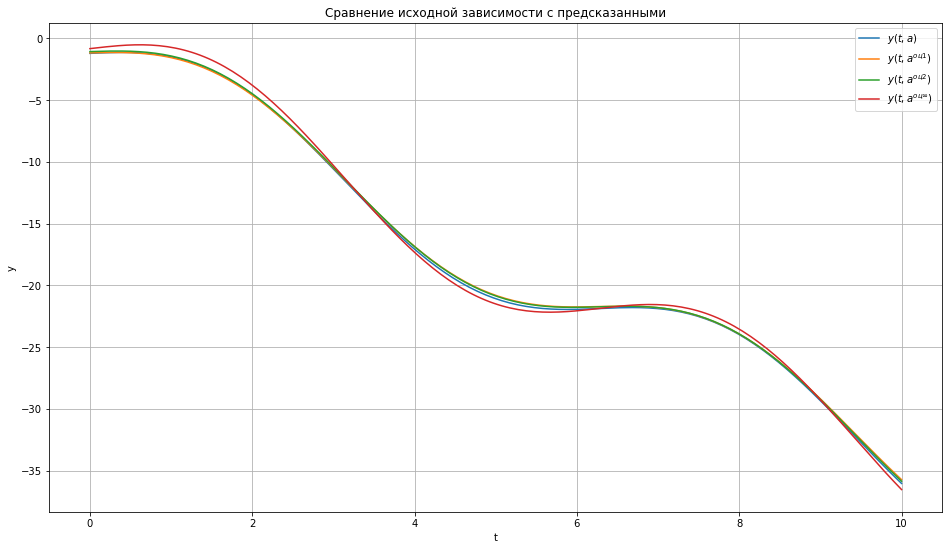

In [14]:
plt.figure(figsize=(16, 9))
plt.plot(t, initial_target, label=r'$y(t, a)$')
plt.plot(t, X @ estimated_a1, label=r'$y(t, a^{оц1})$')
plt.plot(t, X @ estimated_a2, label=r'$y(t, a^{оц2})$')
plt.plot(t, X @ estimated_a_inf, label=r'$y(t, a^{оц\infty})$')
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Сравнение исходной зависимости с предсказанными')
plt.legend()
plt.show()

**Вывод:** Из графика видно, что разные методы предлоижили немного разные зависимости. Более того, нельзя выделить метод, что заведомо справится лучше других, так как в зависимости от заранее сгенерированных параметров $a$ у нас будет разный вид зависимости и потому разные методы будут давать различные по качеству результаты в зависимости от $a$.

## Посмотрим на графики зависимости отклонения модуля параметра от его реального значения в зависимости от $\sigma$ в распределении шума

In [15]:
def visualize_param_distance(X, y, a, metric, simga_step=0.1, max_sigma=3):
    plt.figure(figsize=(16, 9))
    sigmas = np.arange(simga_step, max_sigma + simga_step, simga_step)
    estimator = None
    if metric == 'l1':
        estimator = solve_l1
    elif metric == 'l2':
        estimator = solve_l2
    elif metric == 'l_inf':
        estimator = solve_l_inf
    else:
        raise ValueError
    diffs = np.zeros((len(sigmas), 3))
    for i, sigma in enumerate(sigmas):
        cur_target = y + sps.norm(loc=0, scale=sigma).rvs(len(y))
        estimated_a = estimator(X, cur_target)
        diffs[i] = np.abs(estimated_a - a)
    for i, name in enumerate(names):
        plt.plot(sigmas, diffs[:, i], label=name)
    title = r'{}. Отклонения модуля параметра от его реального значения в зависимости от $\sigma$ в распределении шума'\
            .format(metric)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.xlabel(r'$\sigma$')
    plt.ylabel('отклонение')
    plt.show()

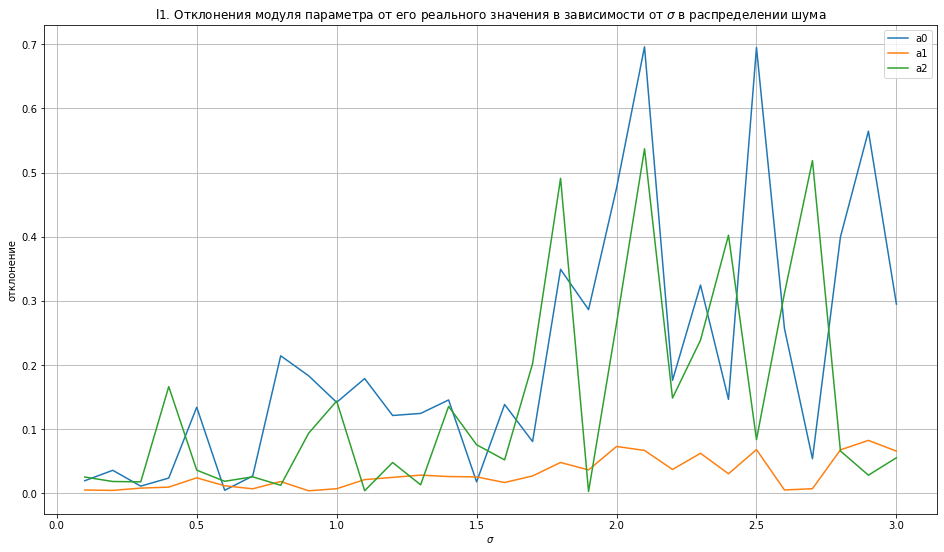

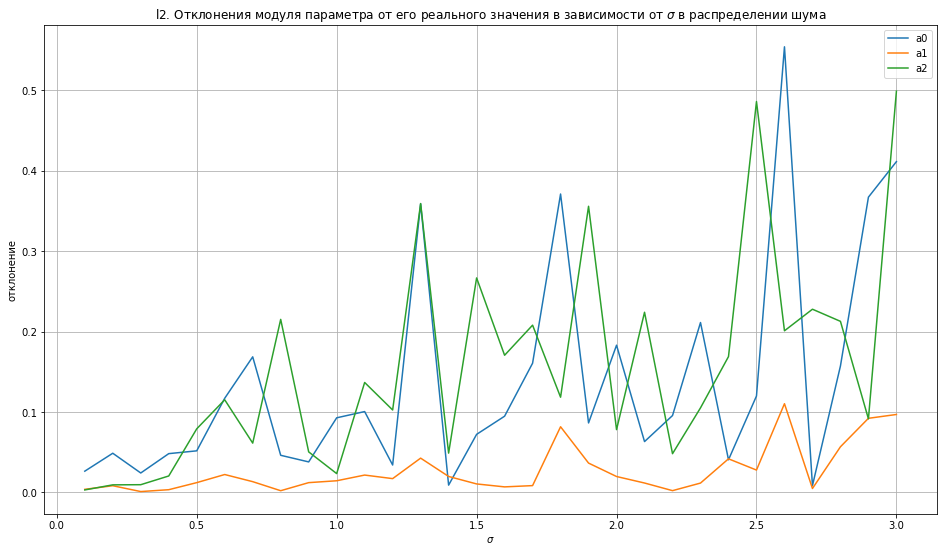

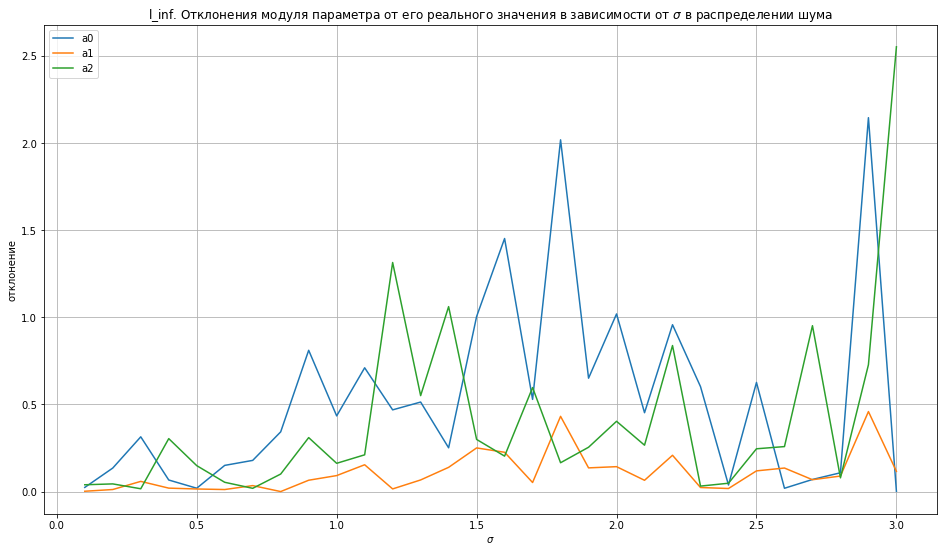

In [16]:
for metric in ['l1', 'l2', 'l_inf']:
    visualize_param_distance(X, initial_target, a, metric)

**Вывод:** Из графиков видно, что с увеличением сигма отклонения приближенных параметров от реальных увеличивается. Это логично, тк обучаемся мы на зашумлённой выборке и потому чем больше шум, тем больше вероятность обучиться в том числе и на шум, а не на саму target перменную. Все три метода лучше всего приближают первых коэф-т, который связан со значением $t$, притом качество его приближения не так сильно страдает от $\sigma$ как качество приближения двух других коэф-ов. Другие два коэф-та оба приближаются не очень хорошо. Я бы сказал, свободный член приближается чуть хуже коэф-та при синусе.

## Проверим оценку на устойчивость к выбросам

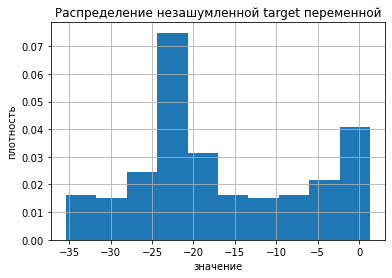

In [17]:
plt.hist(noised_target, density=True)
plt.title('Распределение незашумленной target переменной')
plt.xlabel('значение')
plt.ylabel('плотность')
plt.grid()

In [18]:
initial_target[0] -= 50
initial_target[-1] += 50
noised_target[0] -= 50
noised_target[-1] += 50

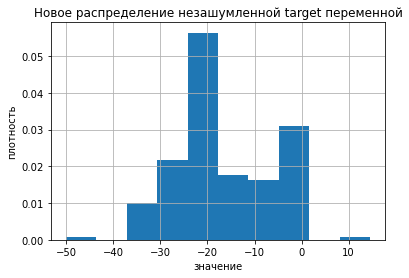

In [19]:
plt.hist(noised_target, density=True)
plt.title('Новое распределение незашумленной target переменной')
plt.xlabel('значение')
plt.ylabel('плотность')
plt.grid()

In [20]:
estimated_a1 = solve_l1(X, noised_target)

In [21]:
for var_name, real_value, estimated_value in zip(names, a, estimated_a1):
    print('{} = {}, приближенное в L1 = {}'.format(var_name, real_value, estimated_value))

a0 = -1.217468213081824, приближенное в L1 = -1.2540236585746727
a1 = -3.287669280788074, приближенное в L1 = -3.259793357647683
a2 = 3.572607202161871, приближенное в L1 = 3.425097214356243


In [22]:
estimated_a2 = solve_l2(X, noised_target)

In [23]:
for var_name, real_value, estimated_value in zip(names, a, estimated_a2):
    print('{} = {}, приближенное в L2 = {}'.format(var_name, real_value, estimated_value))

a0 = -1.217468213081824, приближенное в L2 = -2.5006449405884275
a1 = -3.287669280788074, приближенное в L2 = -2.995401428419589
a2 = 3.572607202161871, приближенное в L2 = 3.272904740961377


In [24]:
estimated_a_inf = solve_l_inf(X, noised_target)

In [25]:
for var_name, real_value, estimated_value in zip(names, a, estimated_a_inf):
    print('{} = {}, приближенное в L_inf = {}'.format(var_name, real_value, estimated_value))

a0 = -1.217468213081824, приближенное в L_inf = -25.11492747555817
a1 = -3.287669280788074, приближенное в L_inf = 1.7583355027639307
a2 = 3.572607202161871, приближенное в L_inf = 5.323054678529537


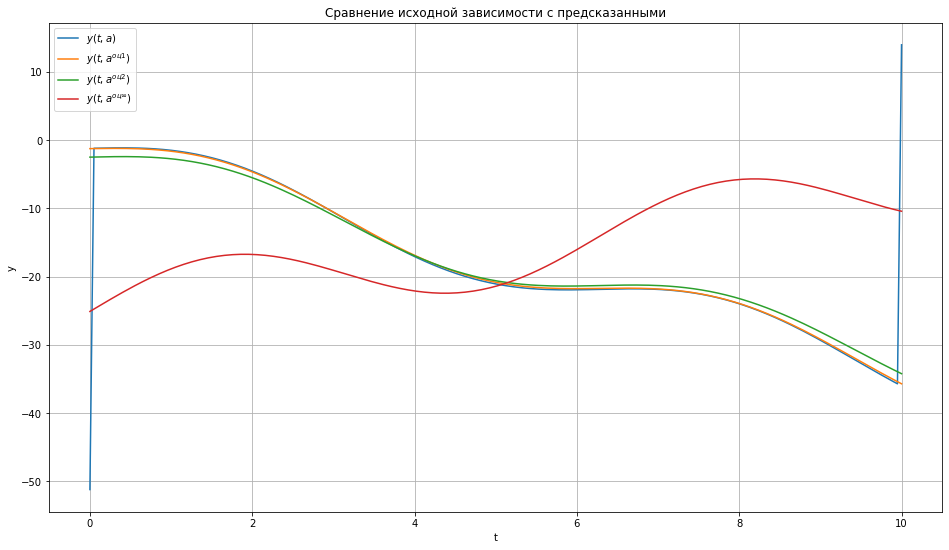

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(t, initial_target, label=r'$y(t, a)$')
plt.plot(t, X @ estimated_a1, label=r'$y(t, a^{оц1})$')
plt.plot(t, X @ estimated_a2, label=r'$y(t, a^{оц2})$')
plt.plot(t, X @ estimated_a_inf, label=r'$y(t, a^{оц\infty})$')
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Сравнение исходной зависимости с предсказанными')
plt.legend()
plt.show()

**Вывод:** Во всех сгенерированных мной примерах $L_\infty$ справился хуже всех. Это логично, тк ему свойственно больше всех переобучаться на выбросы, тк в нем в оптимизируемой функции внимание уделяется самому большому расхождению, а не "среднему". Другие два метода справили получше. Метод квадратов справился похуже и если бы значение target переменной было бы изменено еще сильнее, то его качество еще сильнее бы упало. Это связано с тем, что он очень сильно штрафует за сильные отклонения (квадратичный штраф), в то время как $L_1$ штрафует линейно, что лучше подходит для выборки, содержащей выбросы.